In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

from ipywidgets import interact 

#Modelo
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
df = pd.read_csv('data/Modelar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df.shape[0])
print("Número de variables: %d" % df.shape[1])
if df.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')

Tamaño del conjunto de datos:  103230
Número de variables: 55
El índice es único.


In [3]:
def process_cadastralquality(value):
    dic = {'A': 11, 'B': 10, 'C': 9}
    if value in dic:
        return dic[value]
    else:
        try:
            return 9 - int(value)
        except ValueError:
            return np.nan
        
def process_cadastral(df):
    df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(process_cadastralquality)

In [4]:
process_cadastral(df)
df = df.dropna()

X = df.drop(columns=['CLASE']).copy()
y = df['CLASE'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, shuffle=True, random_state=10)

df_modelar = X_train.merge(y_train, on='ID')
df_modelar_new = X_val.merge(y_val, on='ID')

print("Tamaño del conjunto de datos disponibles: ", len(df_modelar))
print("Tamaño del conjunto de nuevos datos: ", len(df_modelar_new))

Tamaño del conjunto de datos disponibles:  87728
Tamaño del conjunto de nuevos datos:  15482


In [5]:
list_class_order = ['RESIDENTIAL', 'PUBLIC', 'RETAIL', 'OFFICE', 'INDUSTRIAL', 'AGRICULTURE', 'OTHER']

In [9]:
df_modelar[df_modelar['CLASE']=='RESIDENTIAL'].shape

(76647, 55)

(26410, 55)
Residenciales: 0.58
No Residenciales: 0.42


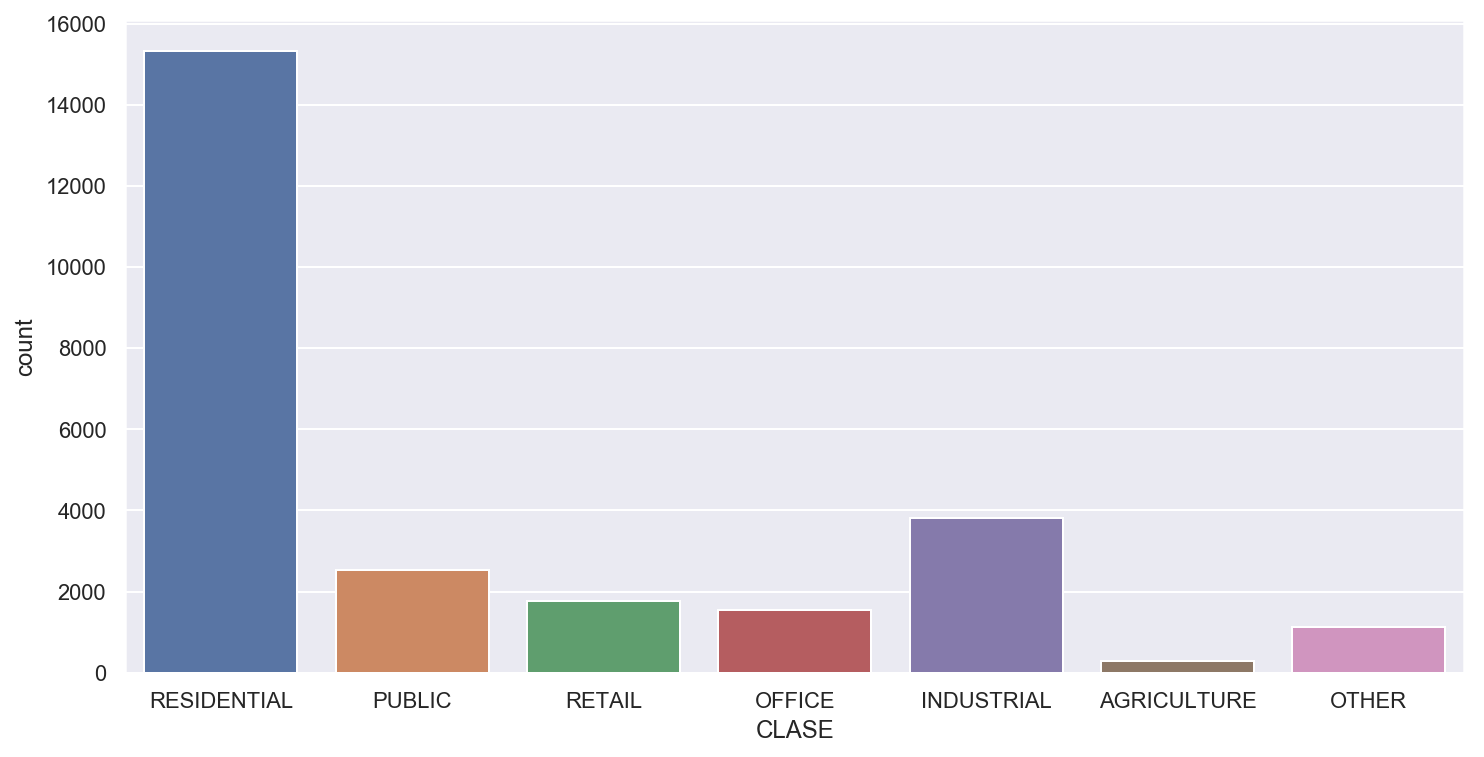

In [52]:
df_modelar_reduce = df_modelar[df_modelar['CLASE']=='RESIDENTIAL'].sample(frac=0.2, random_state=10)
df_modelar_reduce = df_modelar_reduce.append(df_modelar[df_modelar['CLASE']!='RESIDENTIAL'])
print(df_modelar_reduce.shape)
plt.figure(figsize=(12,6))
sns.countplot(df_modelar_reduce['CLASE'], order=list_class_order)
res = len(df_modelar_reduce[df_modelar_reduce['CLASE']=='RESIDENTIAL'])/len(df_modelar_reduce)
no_res = 1-res
print(f"Residenciales: {np.round(res,3)}")
print(f"No Residenciales: {np.round(no_res,3)}")

In [53]:
def process_cadastral_quality(df):
        dic = {'A': 11, 'B': 10, 'C': 9, '1': 8, '2': 7, '3': 6, '4': 5, '5': 4, '6': 3, '7': 3, '8': 1, '9': 0}
        df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(lambda x: dic[x] if x not in [np.NaN] else -1)
        return df

def process_max_building_floor(df):
    df['MAXBUILDINGFLOOR'].fillna(-1, inplace=True)
    return df

def calculate_distance_to_center(df):
    def distance(p0, p1):
        return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)
    center_x = df['X'].sum()/len(df['X'])
    center_y = df['Y'].sum()/len(df['Y'])
    df['distance_to_center'] = df.apply(lambda r: distance([r['X'], r['Y']], [center_x, center_y]), axis=1)
    df['distance_to_center'] = df['distance_to_center'] / df['distance_to_center'].max() #Normalizamos 0,1
    return df

def calculate_context_class(df):
    neigh = pickle.load(open('knn_CCG.model', 'rb'))
    predict = neigh.predict_proba(df[['X', 'Y']])
    aux = pd.DataFrame(predict*5, columns=[ 'C_'+c for c in neigh.classes_ ], index=df.index)
    df = df.merge(aux, on='ID', how='inner') 
    df.drop(columns=['X', 'Y'], inplace=True)
    return df


def calculate_colors_value(df):
    df['mean_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].mean(axis=1)
    df['mean_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].mean(axis=1)
    df['mean_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].mean(axis=1)
    df['mean_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].mean(axis=1)

    #df['max_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].max(axis=1)
    #df['max_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].max(axis=1)
    #df['max_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].max(axis=1)
    #df['max_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].max(axis=1)

    #df['min_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].min(axis=1)
    #df['min_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].min(axis=1)
    #df['min_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].min(axis=1)
    #df['min_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].min(axis=1)

    df['std_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].std(axis=1)
    df['std_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].std(axis=1)
    df['std_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].std(axis=1)
    df['std_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].std(axis=1)
    #df.drop(columns=df.columns[0:44], inplace=True)
    return df

#process_cadastral_quality(df)
#process_max_building_floor(df)
calculate_distance_to_center(df_modelar_reduce)
df_modelar_reduce = calculate_context_class(df_modelar_reduce)
df_modelar_reduce = calculate_colors_value(df_modelar_reduce)

In [54]:
#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('scaler', StandardScaler())])

#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_minsait_trans = ColumnTransformer(transformers=[('num', num_transformer, df_modelar_reduce.select_dtypes(include=np.number).columns.tolist())])

df_modelar_reduce['SUBCLASE'] = (df_modelar_reduce['CLASE'] == 'RESIDENTIAL').astype(int)

#Para nuestro primer modelo vamos a usar todas las variables
X = df_modelar_reduce.drop(columns=['CLASE', 'SUBCLASE']).copy()
y = df_modelar_reduce['SUBCLASE'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [55]:
import xgboost as xgb
rfc_p_model = xgb.XGBClassifier(random_state=10)
underSampling = RandomUnderSampler('majority', random_state=10)
smote = SMOTE('minority', random_state=10)

parameters = {
    'clas__max_depth': [10, 20],
    'clas__n_estimators': [100, 200]
}

minsait_pipe_rfc_p = Pipeline(steps=[('prep', df_minsait_trans), ('clas', rfc_p_model)])

GSR_p = GridSearchCV(minsait_pipe_rfc_p, parameters, cv=5, n_jobs=-1, scoring='f1', refit=True, verbose=1)
GSR_p.fit(X_train, y_train)
    
print("Mejor score: ", GSR_p.best_score_)
print("Mejore configuración de parámetros: ", GSR_p.best_params_)

minsait_pipe_rfc_p = GSR_p.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   35.8s remaining:   35.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished


Mejor score:  0.9103853367288017
Mejore configuración de parámetros:  {'clas__max_depth': 10, 'clas__n_estimators': 100}


In [48]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados")
    print('Accuracy: {}'.format(round(accuracy_score(y, y_pred), 3)))

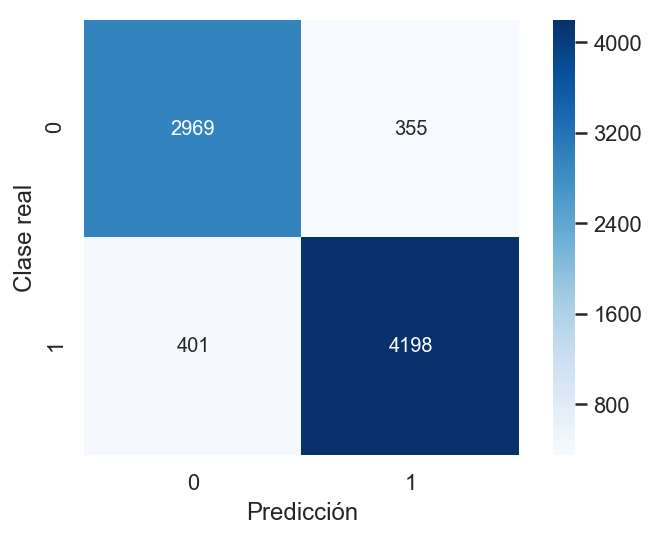

Resultados
Accuracy: 0.905
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      3324
           1       0.92      0.91      0.92      4599

    accuracy                           0.90      7923
   macro avg       0.90      0.90      0.90      7923
weighted avg       0.90      0.90      0.90      7923



In [56]:
y_pred = minsait_pipe_rfc_p.predict(X_test)
show_results(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [57]:
import pickle
pickle.dump(minsait_pipe_rfc_p, open('binary_xgboost_CCG_concurso.model', 'wb'))

# Multi

(11847, 55)
Residenciales: 0.065
No Residenciales: 0.935


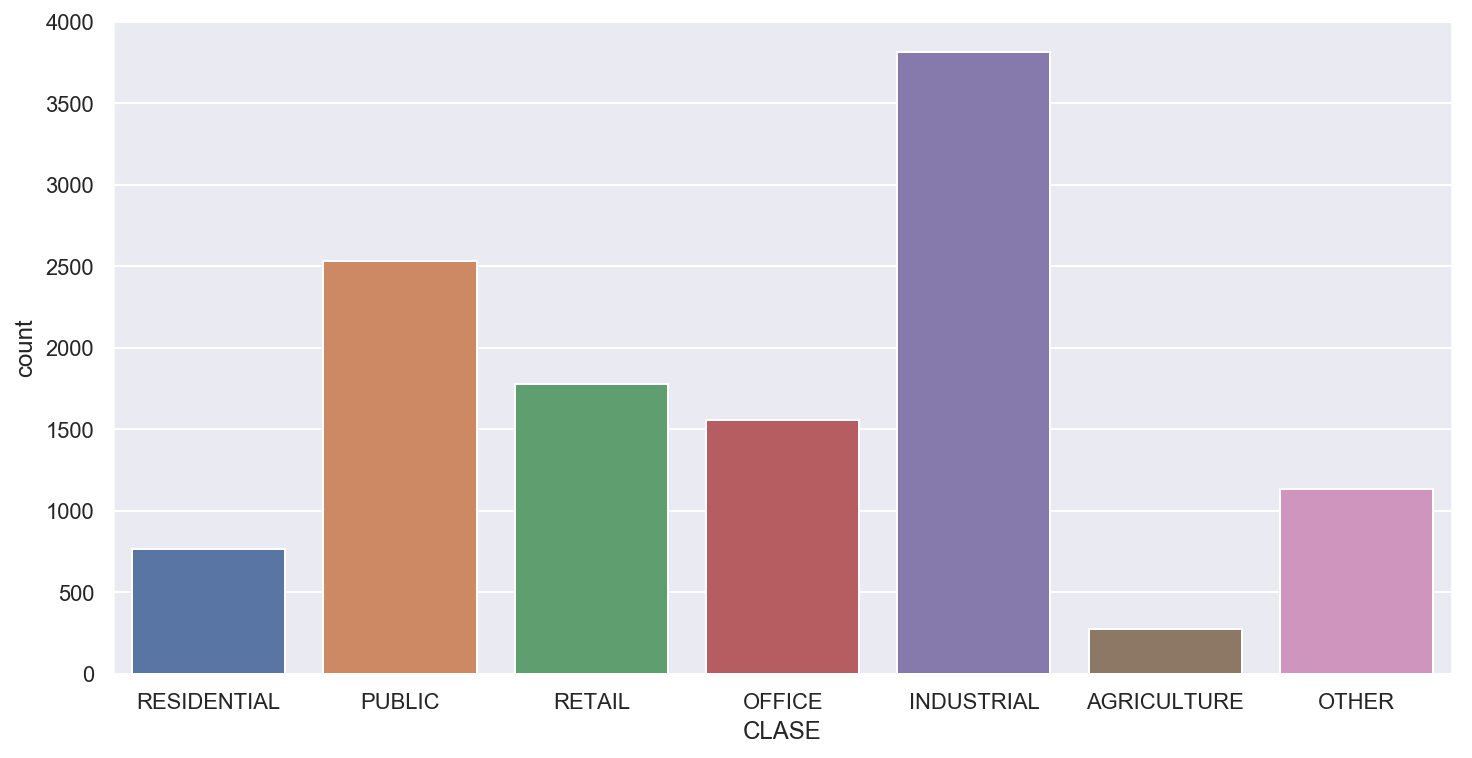

In [59]:
df_modelar_reduce_multi = df_modelar[df_modelar['CLASE']=='RESIDENTIAL'].sample(frac=0.01, random_state=10)
df_modelar_reduce_multi = df_modelar_reduce_multi.append(df_modelar[df_modelar['CLASE']!='RESIDENTIAL'])
print(df_modelar_reduce_multi.shape)
plt.figure(figsize=(12,6))
sns.countplot(df_modelar_reduce_multi['CLASE'], order=list_class_order)
res = len(df_modelar_reduce_multi[df_modelar_reduce_multi['CLASE']=='RESIDENTIAL'])/len(df_modelar_reduce_multi)
no_res = 1-res
print(f"Residenciales: {np.round(res,3)}")
print(f"No Residenciales: {np.round(no_res,3)}")

In [60]:
def process_cadastral_quality(df):
        dic = {'A': 11, 'B': 10, 'C': 9, '1': 8, '2': 7, '3': 6, '4': 5, '5': 4, '6': 3, '7': 3, '8': 1, '9': 0}
        df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(lambda x: dic[x] if x not in [np.NaN] else -1)
        return df

def process_max_building_floor(df):
    df['MAXBUILDINGFLOOR'].fillna(-1, inplace=True)
    return df

def calculate_distance_to_center(df):
    def distance(p0, p1):
        return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)
    center_x = df['X'].sum()/len(df['X'])
    center_y = df['Y'].sum()/len(df['Y'])
    df['distance_to_center'] = df.apply(lambda r: distance([r['X'], r['Y']], [center_x, center_y]), axis=1)
    df['distance_to_center'] = df['distance_to_center'] / df['distance_to_center'].max() #Normalizamos 0,1
    return df

def calculate_context_class(df):
    neigh = pickle.load(open('knn_CCG.model', 'rb'))
    predict = neigh.predict_proba(df[['X', 'Y']])
    aux = pd.DataFrame(predict*5, columns=[ 'C_'+c for c in neigh.classes_ ], index=df.index)
    df = df.merge(aux, on='ID', how='inner') 
    df.drop(columns=['X', 'Y'], inplace=True)
    return df


def calculate_colors_value(df):
    df['mean_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].mean(axis=1)
    df['mean_green'] = df.loc[:, 'Q_G_3_0_1':'Q_G_3_1_0'].mean(axis=1)
    df['mean_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].mean(axis=1)
    df['mean_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].mean(axis=1)

    #df['max_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].max(axis=1)
    #df['max_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].max(axis=1)
    #df['max_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].max(axis=1)
    #df['max_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].max(axis=1)

    #df['min_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].min(axis=1)
    #df['min_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].min(axis=1)
    #df['min_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].min(axis=1)
    #df['min_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].min(axis=1)

    df['std_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].std(axis=1)
    df['std_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].std(axis=1)
    df['std_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].std(axis=1)
    df['std_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].std(axis=1)
    #df.drop(columns=df.columns[0:44], inplace=True)
    return df

#process_cadastral_quality(df)
#process_max_building_floor(df)
calculate_distance_to_center(df_modelar_reduce_multi)
df_modelar_reduce_multi = calculate_context_class(df_modelar_reduce_multi)
df_modelar_reduce_multi = calculate_colors_value(df_modelar_reduce_multi)

In [61]:
#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('scaler', StandardScaler())])

#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_minsait_trans = ColumnTransformer(transformers=[('num', num_transformer, df_modelar_reduce_multi.select_dtypes(include=np.number).columns.tolist())])

#Para nuestro primer modelo vamos a usar todas las variables
X = df_modelar_reduce_multi.drop(columns=['CLASE']).copy()
y = df_modelar_reduce_multi['CLASE'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [62]:
from imblearn.ensemble import BalancedRandomForestClassifier

model = RandomForestClassifier(random_state=10)
#model = BalancedRandomForestClassifier(random_state=10, sampling_strategy='majority')

parameters = {}
parameters['clas__max_depth'] = [5, 10, 20] #Quitamos None para que no sobreajuste al conjunto de train y que no pueda hacer la profundidad que el modelo desee. 
                                            # Lo forzamos a ponerle profundidad, como máximo 20, aunque se podría establecer mayor profundidad pero no queremos que sobreajute a los datos del train.
parameters['clas__n_estimators'] = [100, 200]
#parameters['clas__class_weight'] = ['balanced']

pipe = Pipeline(steps=[('prep', df_minsait_trans),('clas', model)])
GS = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
GS.fit(X_train, y_train)
print(f"Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

model_multilabel = GS.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.2s finished


Mejor score:  0.8484091234637111
Mejore configuración de parámetros:  {'clas__max_depth': 10, 'clas__n_estimators': 100}


In [63]:
y_pred_multi = model_multilabel.predict(X_test)
print(classification_report(y_test, y_pred_multi))

              precision    recall  f1-score   support

 AGRICULTURE       0.86      0.76      0.81        82
  INDUSTRIAL       0.83      0.92      0.87      1144
      OFFICE       0.82      0.68      0.75       466
       OTHER       0.90      0.83      0.86       340
      PUBLIC       0.85      0.91      0.88       759
 RESIDENTIAL       1.00      0.76      0.86       230
      RETAIL       0.86      0.83      0.84       534

    accuracy                           0.85      3555
   macro avg       0.87      0.81      0.84      3555
weighted avg       0.85      0.85      0.85      3555



In [64]:
print(confusion_matrix(y_test, y_pred_multi))

[[  62   17    0    0    2    0    1]
 [   4 1058   25    7   23    0   27]
 [   0   89  318    5   39    0   15]
 [   1   28    4  281   21    0    5]
 [   3   37    8    8  691    0   12]
 [   0   14   11    6   10  175   14]
 [   2   35   20    4   30    0  443]]


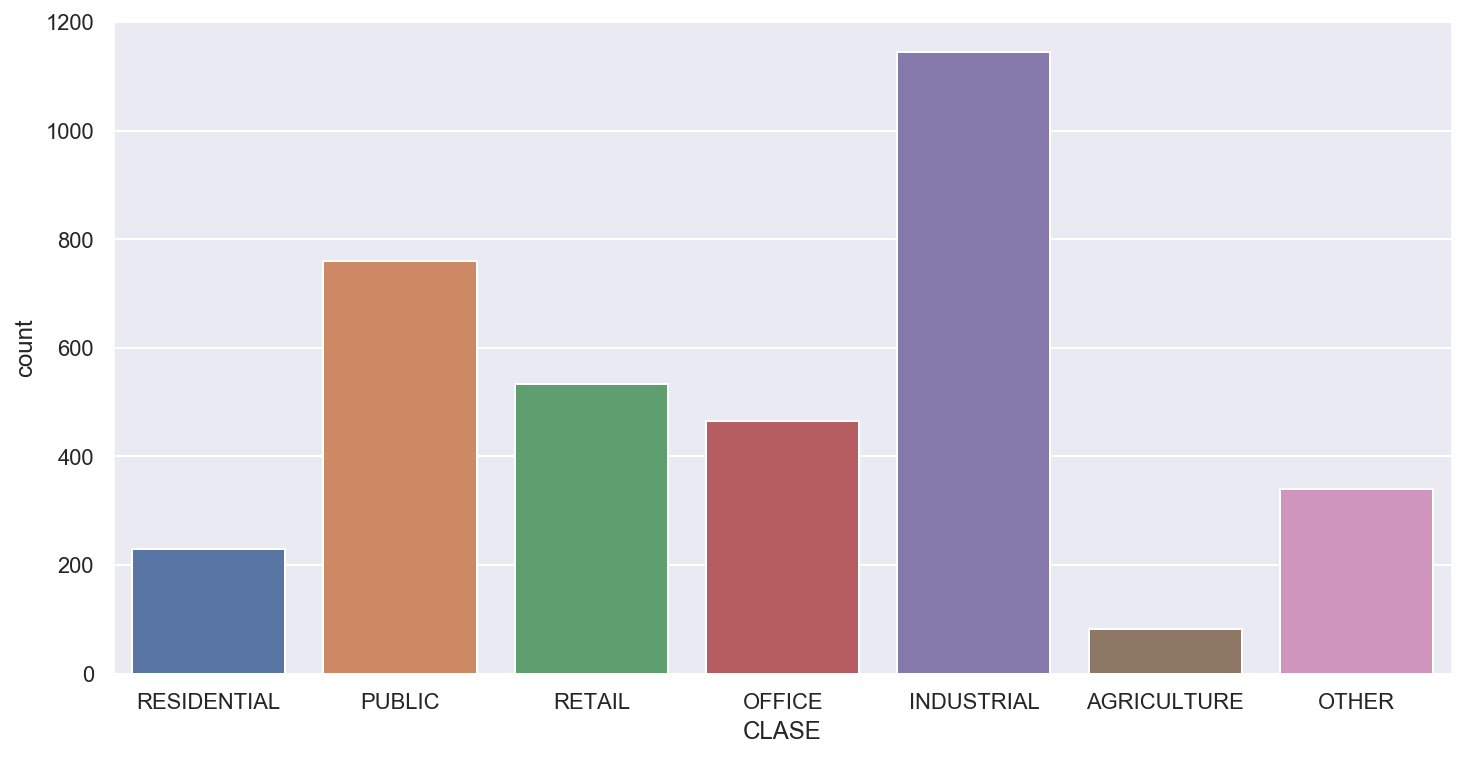

In [65]:
plt.figure(figsize=(12,6))
sns.countplot(y_test, order=list_class_order);

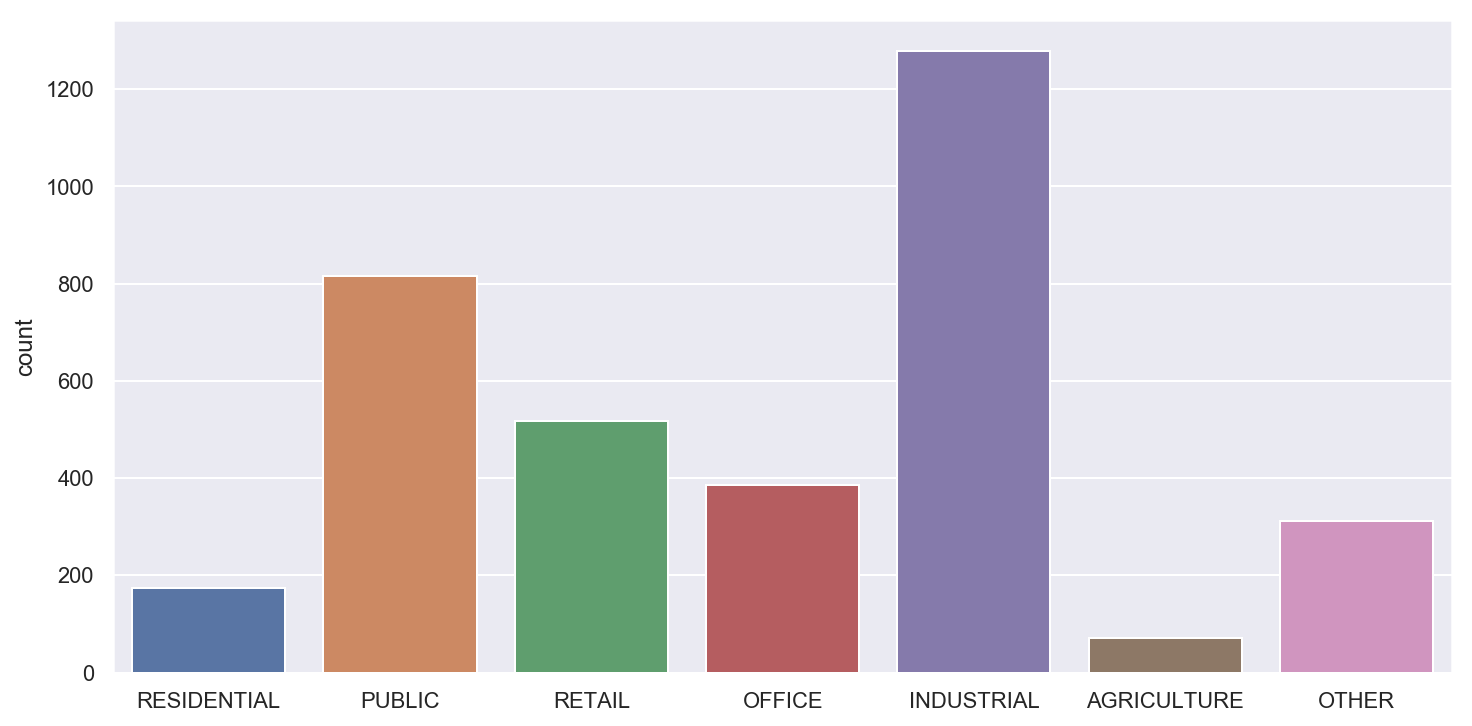

In [66]:
plt.figure(figsize=(12,6))
sns.countplot(y_pred_multi, order=list_class_order);

In [67]:
import pickle
pickle.dump(model_multilabel, open('multilabel_rfc_CCG_concurso.model', 'wb'))